AO3 analysis: fandoms
============

This notebook presents the code used to generate the plots in [post 2]() of [my series on Archive of Our Own metadata]().  The underlying database is not, and will not be, public, but the code here can be reused by others with similar plotting needs.

This particular post discusses the top fandoms on the AO3 by various metrics.

In [2]:
import datetime
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patheffects as path_effects

from ao3db import ao3db
from utils import renorm_kde_plot, rescale_axis, add_log_axis_labels, write_dataframe, format_tag, get_topten_fandoms

In [3]:
# Some settings that will help us make pretty plots
sns.set(style='whitegrid')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Lucida Grande']
rcParams['font.size'] = 18
rcParams['axes.labelsize'] = 18
rcParams['axes.titlesize'] = 22
rcParams['axes.titleweight'] = 'normal'
rcParams['axes.labelpad'] = 20
rcParams['axes.labelcolor'] = 'gray'
rcParams['figure.figsize'] = (12.0, 8.0)
rcParams['legend.fontsize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
figsize = plt.gcf().get_size_inches()
cmap = plt.get_cmap("viridis")
single_color = sns.color_palette('dark')[2]

<Figure size 864x576 with 0 Axes>

In [4]:
db = ao3db()

First plot first: what are the biggest fandoms in the database?  We require "FandomName = ParentName", which indicates that the fandom is its own parent.  For example: the Avengers fandom is one of the biggest on the AO3, but it won't actually show up here, because like a bunch of other properties (such as the X-Men), the Avengers are a subset of the fandom "Marvel."

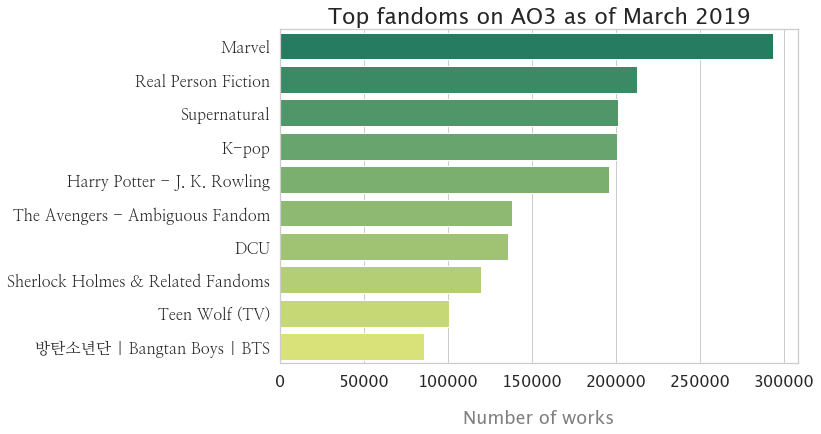

In [5]:
# Grab the fandom data...
#fandom_data = db.get_data("FandomName", "ReportedNum", conditions=["LOWER(OriginalFandomName) = LOWER(ParentName) or ParentName is NULL"]).dropna()
# This is out of date because of how I gathered it. So, directly measure from the AO3.

fandom_data = get_topten_fandoms(db)

# ... and make a barplot.
fig, ax = plt.subplots(gridspec_kw={"bottom": 0.3, "left": 0.3})
sns.barplot(y='FandomName', x='ReportedNum', data=fandom_data, ax=ax, palette='summer') 
#plt.setp( ax.xaxis.get_majorticklabels(), rotation=60, horizontalalignment='right')
ax.set_ylabel("")
ax.set_xlabel("Number of works")

labels = ax.get_yticklabels()
for label in labels:
    label.set_fontname('NanumMyeongjo')
ax.set_yticklabels(labels)
ax.set_title("Top fandoms on AO3 as of March 2019")
fig.savefig("top_fandoms.png")

In [6]:
data_head = db.get_data('ID', 'Date', 'Hits', 'Words', 'FandomName', duplicates=False)

/home/msimet/software/anaconda2/envs/graph-tool/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
/home/msimet/software/anaconda2/envs/graph-tool/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
/home/msimet/software/anaconda2/envs/graph-tool/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all 

<Figure size 864x576 with 0 Axes>

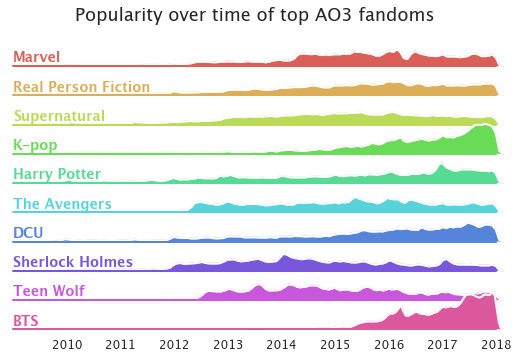

In [6]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Lucida Grande']
rcParams['font.size'] = 14
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 18
rcParams['axes.titleweight'] = 'normal'
rcParams['axes.labelpad'] = 20
rcParams['axes.labelcolor'] = 'gray'
rcParams['figure.figsize'] = (18.0, 30.0)
rcParams['legend.fontsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
fig = plt.figure(figsize=figsize)


data_head['OrdinalDate'] = [d.toordinal() for d in data_head['Date']]

if 'data' not in vars():
    data = data_head.copy()
else:
    data_head = data.copy()
data_head = data_head[data_head["FandomName"].isin(fandom_data["DBFandomName"])]
data_head = data_head.replace({row['DBFandomName']: row['FandomName'] for rid, row in fandom_data.iterrows()})

data_head = data_head[data_head['Date']<datetime.date(2018, 1, 1)]
data_head = data_head[data_head['Date']>=datetime.date(2009, 11, 15)]

# This is drawn from the tutorial at 
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# I couldn't get the figsize keyword to pass properly, so this is a hacky workaround
g = sns.FacetGrid(data_head, row="FandomName", hue="FandomName", aspect=15, height=0.5, palette='hls', row_order=fandom_data['FandomName'], hue_order=fandom_data['FandomName'])

# Draw the densities in a few steps
g.map(sns.kdeplot, "OrdinalDate", clip_on=False, shade=True, alpha=1, lw=1.5, bw=15)
g.map(sns.kdeplot, "OrdinalDate", clip_on=False, color="w", lw=2, bw=15)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    if 'Bangtan Boys' in label:
        label = 'BTS'
    if '&' in label:
        label = label.split('&')[0]
    if '-' in label and label.lower()!='k-pop':
        label = label.split('-')[0]
    if '(TV)' in label:
        label = label[:-5]
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "FandomName")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

desired_xticks = [datetime.date(yr, 1, 1).toordinal() for yr in range(2010, 2019)]
desired_xlim = (datetime.date(2009, 1, 1).toordinal(), datetime.date(2018, 1, 1).toordinal()) # First so we leave room for labels!
xlabels = [datetime.datetime.fromordinal(int(x)).strftime('%Y') for x in desired_xticks]
# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
#g.set(xlim=(desired_xticks[0], data_head["OrdinalDate"].max()))
g.set(xlim=desired_xlim)
g.set(xticks=desired_xticks)
g.set(xticklabels=xlabels)
g.set(xlabel='')
g.despine(bottom=True, left=True)        
g.axes[0][0].set_title("Popularity over time of top AO3 fandoms")
g.savefig("fandoms_by_date.png")

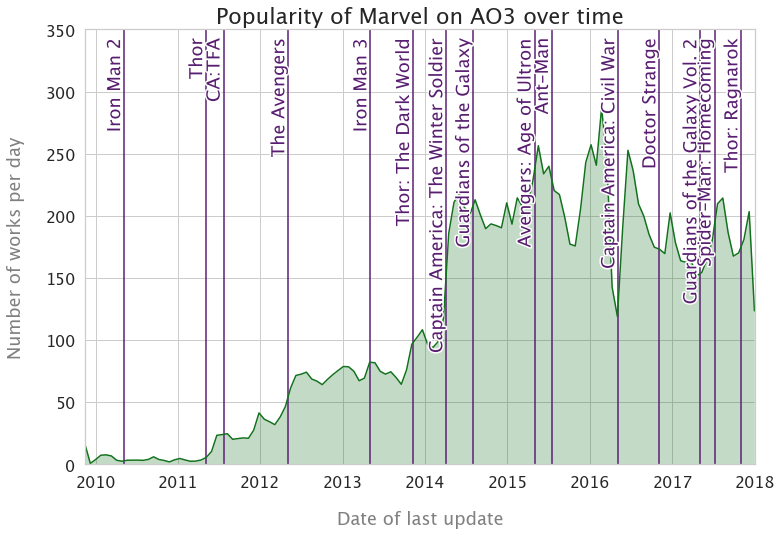

In [7]:
sns.set(style='whitegrid')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Lucida Grande']
rcParams['font.size'] = 18
rcParams['axes.labelsize'] = 18
rcParams['axes.titlesize'] = 22
rcParams['axes.titleweight'] = 'normal'
rcParams['axes.labelpad'] = 20
rcParams['axes.labelcolor'] = 'gray'
rcParams['figure.figsize'] = (12.0, 8.0)
rcParams['legend.fontsize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

fig, ax = plt.subplots()
ax = renorm_kde_plot(data_head.query('FandomName == "{}"'.format('Marvel'))['OrdinalDate'], 
                     ax=ax, color=single_color, bw=15)

ylim = ax.get_ylim()
ytext = 0.5*(ylim[1]+ylim[0])
ann_color = sns.color_palette('dark')[4]
for movie, date in [("Iron Man 2", (2010, 5, 7)),
                          ("Thor", (2011, 5, 6)),
                          ("CA:TFA", (2011, 7, 22)),
                          ("The Avengers", (2012, 5, 4)),
                          ("Iron Man 3", (2013, 5, 3)),
                          ("Thor: The Dark World", (2013, 11, 8)),
                          ("Captain America: The Winter Soldier", (2014, 4, 4)),
                          ("Guardians of the Galaxy", (2014, 8, 1)),
                          ("Avengers: Age of Ultron", (2015, 5, 1)),
                          ("Ant-Man", (2015, 7, 17)),
                          ("Captain America: Civil War", (2016, 5, 6)),
                          ("Doctor Strange", (2016, 11, 4)),
                          ("Guardians of the Galaxy Vol. 2", (2017, 5, 5)),
                          ("Spider-Man: Homecoming", (2017, 7, 7)),
                          ("Thor: Ragnarok", (2017, 11, 3))]:
    date = datetime.date(*date).toordinal()
    ax.vlines(date, ylim[0], ylim[1], color=ann_color)
    text = ax.text(date, 0.98*ylim[1]+0.02*ylim[0], movie, horizontalalignment='right', verticalalignment='top', 
                   color=ann_color, rotation='vertical' )
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                           path_effects.Normal()])

desired_xticks = [datetime.date(yr, 1, 1).toordinal() for yr in range(2010, 2019)]
desired_xlim = (datetime.date(2009, 11, 15).toordinal(), datetime.date(2018, 1, 1).toordinal()) # First so we leave room for labels!
xlabels = [datetime.datetime.fromordinal(int(x)).strftime('%Y') for x in desired_xticks]
# Remove axes details that don't play well with overlap

ax.set_xlim(desired_xlim)
ax.set_ylim(ylim)
ax.set_xticks(desired_xticks)
ax.set_xticklabels(xlabels)
ax.set_xlabel("Date of last update")
ax.set_ylabel("Number of works per day")
ax.set_title("Popularity of Marvel on AO3 over time")
fig.savefig("marvel_works_by_date.png")

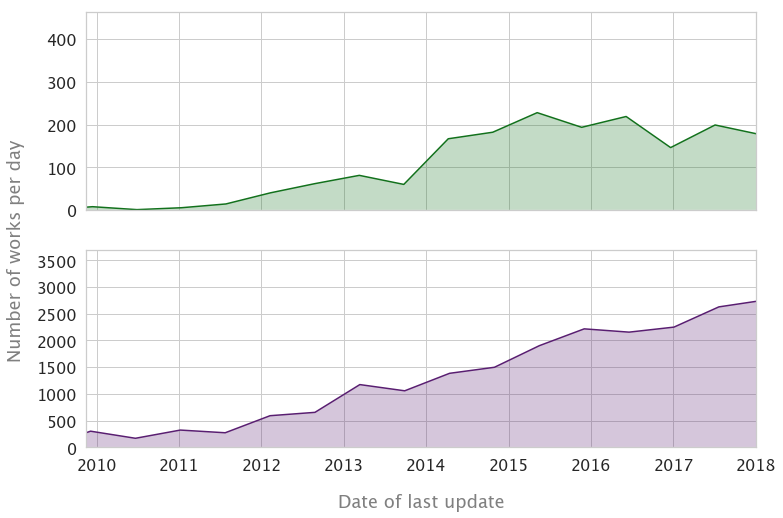

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(wspace=0)
ax1 = renorm_kde_plot(data.query('FandomName == "Marvel"')['OrdinalDate'], ax=ax1, color=single_color, bw=10)
ax2 = renorm_kde_plot(data.query('FandomName != "Marvel"')['OrdinalDate'], ax=ax2, color=ann_color, bw=10)
ax2.set_xlim(desired_xlim)
ax2.set_xticks(desired_xticks)
ax2.set_xticklabels(xlabels)
ax2.set_xlabel("Date of last update")
label = ax2.set_ylabel("Number of works per day")
label.set_position((label.get_position()[0],1)) 
label.set_verticalalignment('center')
fig.savefig("marvel_vs_nonmarvel_works_by_date.png")


In [9]:
for fandom in fandom_data['FandomName']:
    dates = data_head.query('FandomName == "{}"'.format(fandom))['OrdinalDate']
    date, count = scipy.stats.mode(dates)
    if date:
        print("Top day for fandom {}: {}, with {} works, {}".format(fandom, datetime.date.fromordinal(date[0]), count[0], len(dates)))

Top day for fandom Marvel: 2015-12-24, with 452 works, 341024
Top day for fandom Real Person Fiction: 2017-12-24, with 254 works, 189897
Top day for fandom Supernatural: 2016-02-01, with 197 works, 171610
Top day for fandom K-pop: 2017-12-25, with 181 works, 68668
Top day for fandom Harry Potter - J. K. Rowling: 2016-12-04, with 209 works, 130142
Top day for fandom The Avengers - Ambiguous Fandom: 2015-05-03, with 161 works, 121818
Top day for fandom DCU: 2017-12-25, with 217 works, 121185
Top day for fandom Sherlock Holmes & Related Fandoms: 2014-02-14, with 256 works, 134846
Top day for fandom Teen Wolf (TV): 2014-02-15, with 113 works, 91997
Top day for fandom 방탄소년단 | Bangtan Boys | BTS: 2017-12-26, with 146 works, 38646


In [25]:
data = data_head
tfd = db.get_data("FandomName", "OriginalFandomName", "ReportedNum", conditions=["LOWER(OriginalFandomName) = LOWER(ParentName) or ParentName is NULL"]).dropna()
tfd = tfd.sort_values("ReportedNum", ascending=False)
write_dataframe(tfd.head(20), 'top_fandoms_by_counts.dat')
tfd = tfd.set_index("OriginalFandomName")

data_by_num = data.groupby("FandomName").count().sort_values("ID", ascending=False)

# Top fandoms by hits per work, top fandoms by number of works, top fandoms by number of hits
data_by_hits = data.groupby("FandomName").sum()
tfd = tfd.reindex(data_by_hits.index)
data_by_num = data_by_num.reindex(data_by_hits.index)
#print(data_by_hits['Hits'])
#print(data_by_hits['Hits']*tfd['ReportedNum'])
#print(data_by_hits['Hits']/data_by_num["ID"])
data_by_hits['Hits'] *= tfd['ReportedNum']/data_by_num["ID"]
data_by_hits = data_by_hits.dropna()
data_by_hits = data_by_hits.sort_values("Hits", ascending=False)
write_dataframe(data_by_hits.head(20), 'top_fandoms_by_hits.dat')



data_by_num = data_by_num[data_by_num["ID"]>1000]

data = data[data["FandomName"].isin(data_by_num.index)]

data_by_median_hits = data.groupby("FandomName").median().sort_values("Hits", ascending=False)
write_dataframe(data_by_median_hits.head(20), 'top_fandoms_by_median_hits.dat')

In [41]:
colors = sns.color_palette('hls', 25)
for rgb in colors:
    rgb = [int(255*r) for r in rgb]
    print('#%02x%02x%02x' % tuple(rgb))

#db5e56
#db7e56
#db9e56
#dbbe56
#d8db56
#b8db56
#99db56
#79db56
#59db56
#56db73
#56db93
#56dbb3
#56dbd3
#56c3db
#56a3db
#5683db
#5663db
#6956db
#8956db
#a856db
#c856db
#db56ce
#db56ae
#db568e
#db566e


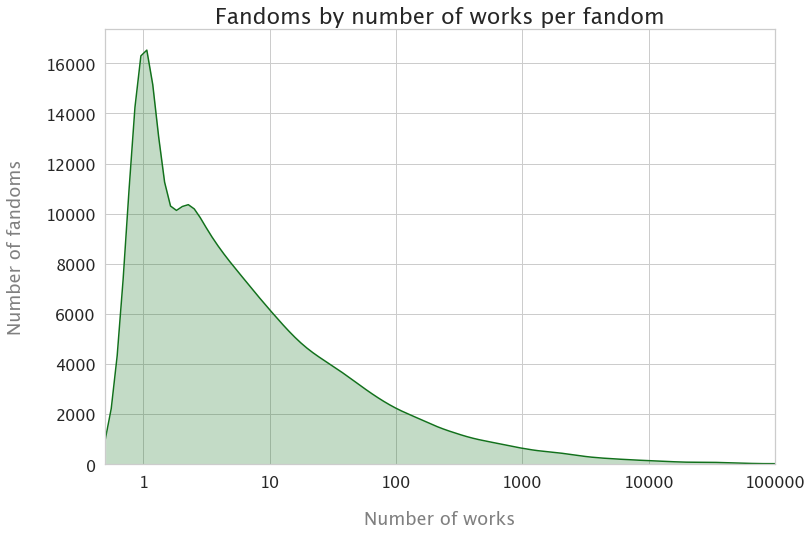

In [14]:
fig, ax = plt.subplots()
renorm_kde_plot(np.log10(data_by_num['Hits'].clip(lower=0.5)), ax=ax, color=single_color)
ax.set_ylabel("Number of fandoms")
ax.set_xlabel("Number of works")
add_log_axis_labels(ax)
ax.set_xlim((np.log10(0.5), 5))
ax.set_title("Fandoms by number of works per fandom")
fig.savefig("number_of_works_hist.png")

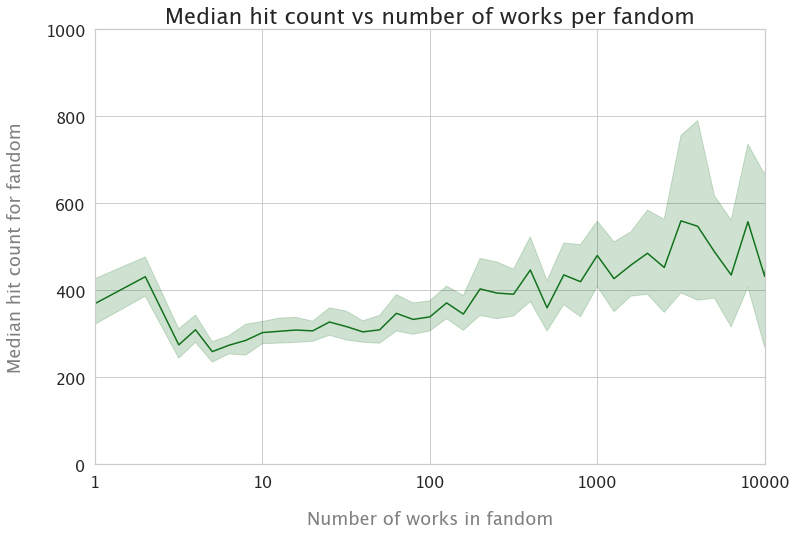

In [15]:
fig, ax = plt.subplots()
data_by_median_hits = data_by_median_hits.reindex(data_by_num.index)
sns.lineplot(x=np.round(np.log10(data_by_num['Hits'].clip(lower=0.5)), decimals=1), y=data_by_median_hits['Hits'], color=single_color, ax=ax)
ax.set_xlabel("Number of works in fandom")
ax.set_ylabel("Median hit count for fandom")
add_log_axis_labels(ax)
ax.set_xlim((0,4))
ax.set_ylim((0, 1000))
ax.set_title("Median hit count vs number of works per fandom")
fig.savefig("hitcount_by_number_of_works.png")

                          FandomName  Median
0                             Marvel  2189.0
1                Real Person Fiction  2012.0
2                       Supernatural  1747.0
3                              K-pop  2645.0
4       Harry Potter - J. K. Rowling  2028.0
5    The Avengers - Ambiguous Fandom  2215.0
6                                DCU  1965.0
7  Sherlock Holmes & Related Fandoms  1705.0
8                     Teen Wolf (TV)  1983.0
9         방탄소년단 | Bangtan Boys | BTS  3044.0


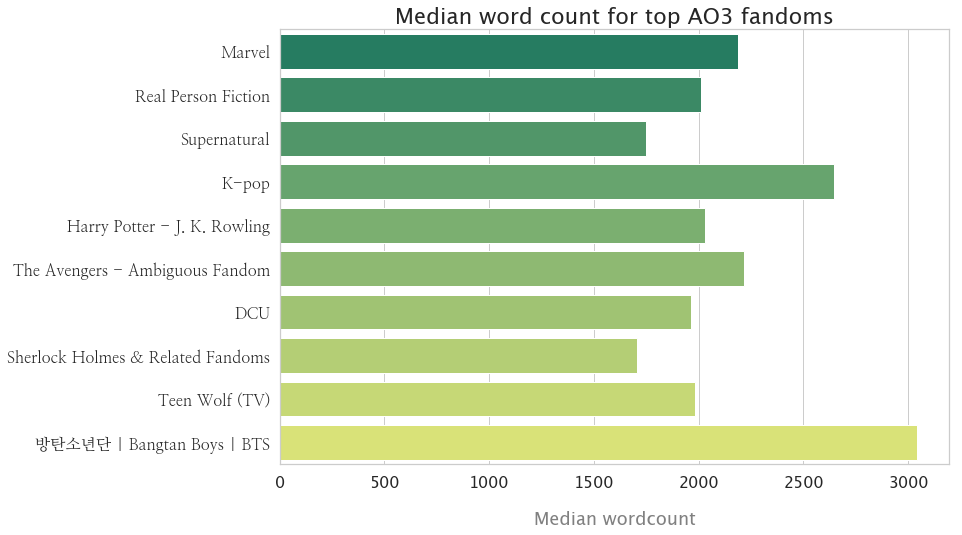

In [13]:
medians = []
for fandom in fandom_data['DBFandomName']:
    words = data.query('FandomName == "{}"'.format(fandom))['Words'].replace('', 0).map(int)
    medians.append(words.median())
this_df = pd.DataFrame({"FandomName": fandom_data['FandomName'], "Median": medians})
print(this_df)

fig, ax = plt.subplots()
sns.barplot(y='FandomName', x='Median', data=this_df, ax=ax, palette='summer') 
#plt.setp( ax.xaxis.get_majorticklabels(), rotation=60, horizontalalignment='right')
ax.set_ylabel("")
ax.set_xlabel("Median wordcount")
labels = ax.get_yticklabels()
for label in labels:
    label.set_fontname('NanumMyeongjo')
ax.set_yticklabels(labels)
ax.set_title("Median word count for top AO3 fandoms")
fig.savefig("fandom_median_wordcounts.png")